The purpose of this notebook is to demonstrate how to make comparisons between different sets of results.  This is demonstrated by using results of a test query using TRAPI.  The first sections [TRAPI query results](#TRAPI-query-results) is to get a set of data to use for comparisons and place them in the same output directory shown in the cell immediately below.  Here, the pathways `Buprenorphine-OPRM1-Asterixis` and `Brixadi-OPRM1-Asterixis` are compared.

The compare_results() function is then demonstrated by taking the results from the query and showing a Venn diagram plot showing the number of edges in common and comparison plot showing missing edges.  For this notebook, if a different query is used or a different comparison is to be made, the files being read for comparison must be specified manually.

In [2]:
from datetime import datetime
from pathlib import Path

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d_%H%M%S")
write_dir = Path("output/compare",str(dt_string))
print(write_dir)
write_dir.mkdir(parents=True, exist_ok=True)

output\compare\2023-05-19_142052


## TRAPI query results

Using the Name Resolver and test case from the `HelloRobokop` notebook series, a list of input IDs is generated from the search term `Buprenorphine`.

In [3]:
import requests
import json

import pprint
pp = pprint.PrettyPrinter(indent=5)

search_string = 'Buprenorphine'
results = requests.post(f'https://name-resolution-sri.renci.org/lookup?string={search_string}&offset=0&limit=10')
results_json = results.json()
input_node_id_list = list(results_json.keys())

nn_query = {
  "curies": input_node_id_list,
  "conflate": True
}

results = requests.post('https://nodenormalization-sri.renci.org/get_normalized_nodes',json=nn_query)

print(input_node_id_list)

['PUBCHEM.COMPOUND:644073', 'PUBCHEM.COMPOUND:9848990', 'UMLS:C0524040', 'PUBCHEM.COMPOUND:9811785', 'UMLS:C0799646', 'PUBCHEM.COMPOUND:91745467', 'UMLS:C0701445', 'PUBCHEM.COMPOUND:3033050', 'UMLS:C0366373', 'UMLS:C1171048']


In [4]:
query={
    "message": {
      "query_graph": {
        "edges": {
          "e00": {
            "subject": "n00",
              "object": "n01",
          "predicates":["biolink:related_to"]
          },
          "e01": {
            "subject": "n01",
              "object": "n02",
          "predicates":["biolink:related_to"]
          }
        },
        "nodes": {
          "n00": {
            "ids": input_node_id_list,
              # "ids": ['PUBCHEM.COMPOUND:644073', 'PUBCHEM.COMPOUND:9848990'], # CURIES for Buprenorphine and Brixadi, respectively
            "categories": ["biolink:ChemicalEntity"]
          },
          "n01": {
              "categories": ["biolink:Gene"]
          },
          "n02": {
            "ids": ["HP:0001337"],
            "categories": ["biolink:DiseaseOrPhenotypicFeature"]
          }
        }
      }
    }
  }

robokop_submit_url = " http://automat-u24.apps.renci.org/robokopkg/1.3/query"
response = requests.post(robokop_submit_url,json=query)
print(response.status_code)
number_pathway_results = len(response.json()['message']['results'])
print(len(response.json()['message']['results']))

200
8


In [7]:
import pandas as pd
import os

kg = response.json()['message']['knowledge_graph']
cols = []
for node in sorted(response.json()['message']['results'][0]['node_bindings'].keys()):
    cols.append(node)
    cols.append(node + '_name')
results_df = pd.DataFrame(columns = cols)

results_list = []
for result in response.json()['message']['results']:
    result_dict = {}
    for node in sorted(result['node_bindings'].keys()):
        node_id = result['node_bindings'][node][0]['id']
        result_dict[node] = node_id
        result_dict[node + '_name'] = kg['nodes'][node_id]['name']

    results_list.append(pd.DataFrame([result_dict]))
results_df = pd.concat(results_list)
display(results_df)

if not os.path.exists(os.path.join(write_dir,"TRAPI")):
    os.mkdir(os.path.join(write_dir,"TRAPI"))
results_df.to_csv(os.path.join(write_dir,'TRAPI/pathways_TRAPI_automat.csv'), index=False)

combined_node_list = ["_".join([row[1].replace(" ", "_"), row[3].replace(" ", "_"), row[5].replace(" ", "_")]) for row in results_df[cols].to_numpy()]
pp.pprint(combined_node_list)

,n00,n00_name,n01,n01_name,n02,n02_name
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0200085,Limb tremor
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0002345,Action tremor
0,PUBCHEM.COMPOUND:9848990,Brixadi,NCBIGene:4988,OPRM1,HP:0012164,Asterixis
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0025387,Pill-rolling tremor
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0001337,Tremor
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0002322,Resting tremor
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0002174,Postural tremor
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:4988,OPRM1,HP:0012164,Asterixis


[    'Buprenorphine_CYP2D6_Limb_tremor',
     'Buprenorphine_CYP2D6_Action_tremor',
     'Brixadi_OPRM1_Asterixis',
     'Buprenorphine_CYP2D6_Pill-rolling_tremor',
     'Buprenorphine_CYP2D6_Tremor',
     'Buprenorphine_CYP2D6_Resting_tremor',
     'Buprenorphine_CYP2D6_Postural_tremor',
     'Buprenorphine_OPRM1_Asterixis']


Following the same steps to get the pathway results in `HelloRobokop_TRAPI.ipynb`, we see that there are two pathways with the same middle and end nodes, `OPRM1` and `Asterixis`.  These two pathways are extracted and used to demonstrate the `compare_results()` function.

In [9]:
from collections import Counter
import json
import pprint
pp = pprint.PrettyPrinter(indent=5)

for i in range(number_pathway_results):
    if "OPRM1_Asterixis" not in combined_node_list[i]:
        continue
        
    print(f"Pathway result: {combined_node_list[i]}")
    edge_bindings = response.json()['message']['results'][i]['edge_bindings']

    edge_ids = []
    for edge_name, edge_list in edge_bindings.items():
        edge_ids.append({edge_name: [x['id'] for x in edge_list]})

    string_out_list = []
    for edge_dict in edge_ids:
        for edge_name, edge_list in edge_dict.items():
            for edge_id in edge_list:
                subject_id = response.json()['message']['knowledge_graph']['edges'][edge_id]['subject']
                subject = response.json()['message']['knowledge_graph']['nodes'][subject_id]['name']
                predicate = response.json()['message']['knowledge_graph']['edges'][edge_id]['predicate']
                object_id = response.json()['message']['knowledge_graph']['edges'][edge_id]['object']
                object = response.json()['message']['knowledge_graph']['nodes'][object_id]['name']
                string_out = f"{subject} -> {predicate} -> {object}"
                string_out_list.append(string_out)
    string_out_dict = dict(Counter(string_out_list).items())
    pp.pprint(string_out_dict)
    print("")
    
    if not os.path.exists(os.path.join(write_dir,"TRAPI")):
        os.mkdir(os.path.join(write_dir,"TRAPI"))
    with open(os.path.join(write_dir,"TRAPI",combined_node_list[i]+".txt"), 'w') as convert_file:
        convert_file.write(json.dumps(string_out_dict))
        

Pathway result: Brixadi_OPRM1_Asterixis
{    'Brixadi -> biolink:affects -> OPRM1': 1,
     'OPRM1 -> biolink:genetic_association -> Asterixis': 1}

Pathway result: Buprenorphine_OPRM1_Asterixis
{    'Buprenorphine -> biolink:affects -> OPRM1': 4,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> OPRM1': 1,
     'Buprenorphine -> biolink:related_to -> OPRM1': 1,
     'OPRM1 -> biolink:genetic_association -> Asterixis': 1}



Results for the two pathways are stored in the files shown below.  The contents of these files can be loaded into dictionaries and used as input for the `compare_function()`.

In [6]:
for node_set in combined_node_list:
    if "OPRM1_Asterixis" in node_set:
        print(os.path.join(write_dir,node_set+".txt"))

output\compare\2023-05-19_142052\Brixadi_OPRM1_Asterixis.txt
output\compare\2023-05-19_142052\Buprenorphine_OPRM1_Asterixis.txt


## compare_results() function

Below is a demo of using `compare_results()` to compare the output from the pathways `Buprenorphine-OPRM1-Asterixis` and `Brixadi-OPRM1-Asterixis` as extracted from the results above.  Note that both sets of results were generated using TRAPI.

In [10]:
import pprint
pp = pprint.PrettyPrinter(indent=5)

In [11]:
# Reading from TRAPI results
file_to_read = os.path.join(write_dir,"TRAPI","Buprenorphine_OPRM1_Asterixis.txt")
with open(file_to_read, 'r') as file:
    jsonString = file.read()
dict_trapi_1 = json.loads(jsonString)
pp.pprint(dict_trapi_1)

{    'Buprenorphine -> biolink:affects -> OPRM1': 4,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> OPRM1': 1,
     'Buprenorphine -> biolink:related_to -> OPRM1': 1,
     'OPRM1 -> biolink:genetic_association -> Asterixis': 1}


In [12]:
# Reading from TRAPI results
file_to_read = os.path.join(write_dir,"TRAPI","Brixadi_OPRM1_Asterixis.txt")
with open(file_to_read, 'r') as file:
    jsonString = file.read()
dict_trapi_2 = json.loads(jsonString)
pp.pprint(dict_trapi_2)

{    'Brixadi -> biolink:affects -> OPRM1': 1,
     'OPRM1 -> biolink:genetic_association -> Asterixis': 1}


In [13]:
from datetime import datetime
from pathlib import Path

if not os.path.exists(os.path.join(write_dir,"compare")):
    os.mkdir(os.path.join(write_dir,"compare"))

Installing matplotlib and matplotlib_venn if not already installed

In [ ]:
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install matplotlib_venn

In [16]:
import matplotlib.pyplot as plt
import sys
from matplotlib_venn import venn2

def compare_results(dict_one, dict_two, output_file_name, label1, label2):
    # This function takes the results of two dictionaries created by the TRAPI and Cypher query Jupyter notebooks and gets the following:
    #  -finds how many edges each set has in common, including having the same and different number of occurrences
    #  -finds edges exclusive to each set
    #  -plots a venn diagram representation of common edges and differences between sets
    #    -edges with the same predicate but different occurrences are treated as differences in the diagram
    # INPUT:
    #  -dict_one: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -dict_two: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -output_file_name: name of the file to write to with output results
    #  -label1/label2: Text and figure label for first and second input dictionaries, respectively
    # OUTPUT:
    #  -compare .txt file listing each of the following:
    #    -Common edges
    #    -Common edge predicates with different counts
    #    -Edges exclusive to the first input dictionary
    #    -Edges exclusive to the second input dictionary
    #  -Venn diagram showing number of common and different edges between the two input sets
    with open(output_file_name, "w") as f:
        common_edge_same_list = []
        common_edge_diff_list = []
        input_one_only_list = []
        input_two_only_list = []
        for key in dict_one.keys():
            if key in dict_two.keys():
                if dict_one[key] == dict_two[key]:
                    common_edge_same_list.append(f"{key} - {dict_two[key]}")
                else:
                    common_edge_diff_list.append(f"{key}\n\t{label1} - {dict_one[key]}\n\t{label2} - {dict_two[key]}")
            else:
                input_one_only_list.append(f"{key} - {dict_one[key]}")

        for key in dict_two.keys():
            if key not in dict_one.keys():
                input_two_only_list.append(f"{key} - {dict_two[key]}")

        f.write("Common edges:\n")
        for edge in common_edge_same_list:
            f.write(edge)
            f.write("\n")
        f.write("\nCommon edges with different count:\n")
        for edge in common_edge_diff_list:
            f.write(edge)
            f.write("\n")
        f.write(f"\n{label1} only:\n")
        for edge in input_one_only_list:
            f.write(edge)
            f.write("\n")
        f.write(f"\n{label2} only:\n")
        for edge in input_two_only_list:
            f.write(edge)
            f.write("\n")
    
    venn2(subsets = (len(input_one_only_list), len(input_two_only_list), len(common_edge_same_list)+len(common_edge_diff_list)), set_labels = (label1, label2))
    plt.savefig(output_file_name.replace(".txt","_venn.png"))
    plt.show()
    
    df_merge_input = pd.DataFrame([dict_one,dict_two]).T
    df_merge_input.columns = [label1,label2]
    df_merge_input[label1][df_merge_input[label1].isnull()] = 0
    df_merge_input[label2][df_merge_input[label2].isnull()] = 0
    df_merge_input['set_difference'] = df_merge_input[label2] - df_merge_input[label1]
    display(df_merge_input)

    y = df_merge_input['set_difference']
    x = df_merge_input.index.values.tolist()
    plt.figure()
    plt.barh(x,y)
    plt.gca().invert_yaxis()
    plt.xlabel(f'{label1} vs {label2}')
    # plt.title("Automat vs ROBOKOPKG")
    # plt.tick_params(left = False, labelleft = False)
    max_set_difference = max(df_merge_input['set_difference'])
    min_set_difference = min(df_merge_input['set_difference'])
    plt.xlim([min(-3,min_set_difference),max(3,max_set_difference)])
    plt.savefig(output_file_name.replace(".txt","_diffplot.png"), bbox_inches="tight")

The comparisons below show how many edges are unique to each set of results and how many edges are in common.  For the query with the initial node being `Buprenorphine`, there are 6 edges found unique to that query, while for `Brixadi`, there is only one.  The common edge between these two queries is `OPRM1 -> biolink:genetic_association -> Asterixis`, represented in the middle 1 of the Venn diagram and as the empty space in the difference plot.

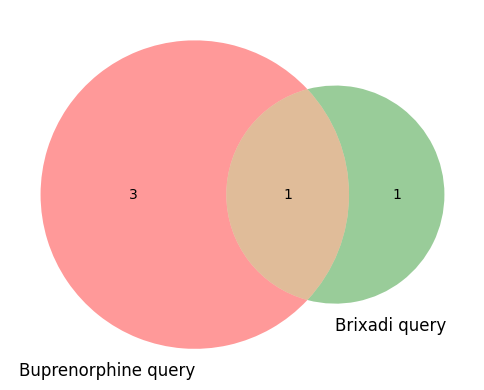

,Buprenorphine query,Brixadi query,set_difference
Buprenorphine -> biolink:affects -> OPRM1,4.0,0.0,-4.0
Buprenorphine -> biolink:directly_physically_interacts_with -> OPRM1,1.0,0.0,-1.0
Buprenorphine -> biolink:related_to -> OPRM1,1.0,0.0,-1.0
OPRM1 -> biolink:genetic_association -> Asterixis,1.0,1.0,0.0
Brixadi -> biolink:affects -> OPRM1,0.0,1.0,1.0


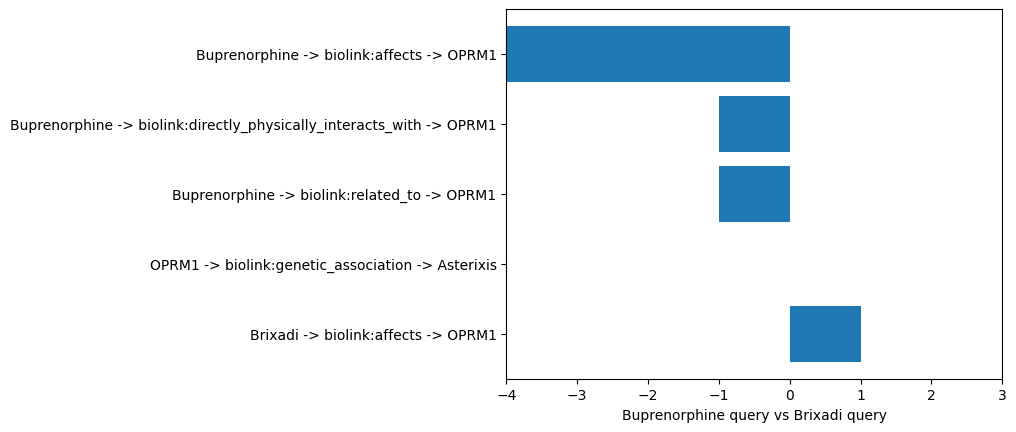

In [17]:
# Demo
output_file_name = os.path.join(write_dir,"compare_brixadi_buprenorphine.txt")
compare_results(dict_trapi_1,dict_trapi_2, output_file_name, "Buprenorphine query", "Brixadi query")